## Tumor Detection with Transfer Learning from Gigapixel Pathology Images

Group Members & UNI:


Chengtian, Xu (cx2168) <br/>
Wei, Han (wh2365) <br/>
Yang, Gao (yg2499)

#### Project Github Link: https://git.io/tumor_cancer <br>
#### YouTube: [Demo](https://www.youtube.com/watch?v=3qS0IxjzOok&feature=youtu.be), [Code Walkthrough](https://www.youtube.com/watch?v=7Ut5lu7wIjI&feature=youtu.be)

Training and Testing Data: [Data Resource](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5)

Reference: <br/>

starter code: https://github.com/random-forests/applied-dl/blob/master/project/starter-code.ipynb


Yun Liu et al., Detecting Cancer Metastases on Gigapixel Pathology Images: https://arxiv.org/abs/1703.02442





In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install h5py pyyaml
!pip install -U -q PyDrive

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (150 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(1,0,0)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked


## Load Training Slides and Masks from Google Drive

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

In [0]:
print(local_download_path)

/root/data


In [0]:
file_list = drive.ListFile({'q': "title contains 'tumor' and title contains '.tif' and '1Z9P8794Ioo2FcmO6Ld-dh_y5f4CTVZ3P' in parents"}).GetList()

In [0]:
file_list = drive.ListFile({'q': "title contains 'tumor' and title contains '.tif'"}).GetList()

In [0]:
print(file_list)

[GoogleDriveFile({'kind': 'drive#file', 'id': '1PzKqVVjgjjUrfonnDpLeuNAKeJgLSQgM', 'etag': '"Pu5D-rrLQ1obLibLazOjcgPU6jw/MTU1Nzg3ODk5NTE4OA"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1PzKqVVjgjjUrfonnDpLeuNAKeJgLSQgM', 'webContentLink': 'https://drive.google.com/a/barnard.edu/uc?id=1PzKqVVjgjjUrfonnDpLeuNAKeJgLSQgM&export=download', 'alternateLink': 'https://drive.google.com/a/barnard.edu/file/d/1PzKqVVjgjjUrfonnDpLeuNAKeJgLSQgM/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/a/barnard.edu/file/d/1PzKqVVjgjjUrfonnDpLeuNAKeJgLSQgM/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/image/tiff', 'title': 'Copy of tumor_002.tif', 'mimeType': 'image/tiff', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2019-05-15T00:09:55.188Z', 'modifiedDate': '2019-05-15T00:09:55.188Z', 'modifiedByMeDate': '2019-05-15T00:09:55.188Z'

In [0]:
train_slides = ['tumor_016.tif','tumor_101.tif', 'tumor_084.tif', 
                 'tumor_094.tif', 'tumor_096.tif']
train_masks = ['tumor_016_mask.tif','tumor_101_mask.tif', 'tumor_084_mask.tif', 
                'tumor_094_mask.tif', 'tumor_096_mask.tif']

In [0]:
for f in file_list:
  fname = f['title'].split()[-1]
  if fname in train_slides or fname in train_masks:
    fname = f['title'].split()[-1]
    fname = os.path.join(local_download_path, fname)
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
 

downloading to /root/data/tumor_016.tif
downloading to /root/data/tumor_016_mask.tif
downloading to /root/data/tumor_084.tif
downloading to /root/data/tumor_094.tif
downloading to /root/data/tumor_096.tif
downloading to /root/data/tumor_084_mask.tif
downloading to /root/data/tumor_094_mask.tif
downloading to /root/data/tumor_096_mask.tif
downloading to /root/data/tumor_101.tif
downloading to /root/data/tumor_101_mask.tif
downloading to /root/data/tumor_016_mask.tif
downloading to /root/data/tumor_016.tif


In [0]:
for f in file_list:
  if f['title'] in train_slides or f['title'] in train_masks:
    fname = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
 

In [0]:
slide_data = []

for image in train_slides: 
  slide_data.append(open_slide('/root/data/' + image))
  
  
mask_data = []

for image in train_masks:
  mask_data.append(open_slide('/root/data/' + image))

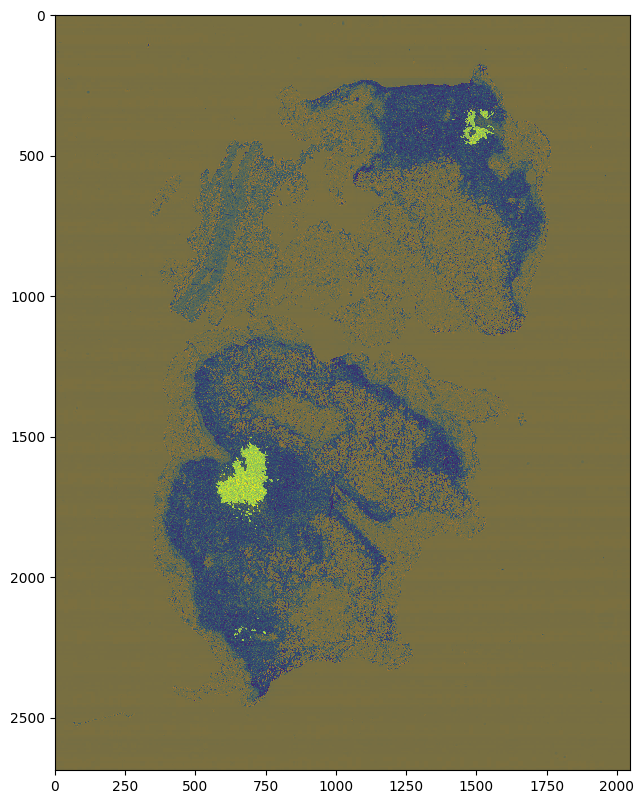

In [0]:
slide = open_slide('/root/data/'+ train_slides[2])
slide_image = (read_slide(slide,x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])[:,:,0])
mask = open_slide('/root/data/'+ train_masks[2])
mask_image = (read_slide(mask,x=0, 
                        y=0, 
                        level=5, 
                        width=mask.level_dimensions[5][0], 
                        height=mask.level_dimensions[5][1])[:,:,0])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5) # Red regions contains cancer.

In [0]:
def hasTumor(mask, size = 128):
  
  patch_size = mask.shape[0]
  offset = int((patch_size-size)/2)
  
  return np.sum(mask[offset:offset+size, offset:offset+size])>0

In [0]:
from matplotlib.colors import Normalize

def plot_triplet(level, square_size, slide, mask, tissue, fname):

    patch_size = slide.shape[0]

    offset = int((patch_size - square_size)/2)
    
    tissue_ratio = np.sum(tissue[:,:,0])/(patch_size**2)
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    
    colors = Normalize(0, 1)(mask)
    colors = plt.cm.magma(colors)
    colors[..., -1] = mask
    
    a = axes[0]
    a.imshow(slide)
    a.set_title('%s, level: %d' % (fname, level))
    a.grid(False)

    a = axes[1]
    a.imshow(slide)
    a.grid(False)
    a.imshow(colors, cmap='magma', vmin=0, vmax=1, alpha=0.8)
    a.plot([offset, offset+square_size, offset+square_size, offset, offset],
                 [offset, offset, offset+square_size, offset+square_size, offset], 'r')
    a.set_title('Masked')

    a = axes[2]
    a.imshow(tissue, cmap='plasma', vmin=0, vmax=1), axes[2].grid(False)
    a.imshow(colors, cmap='magma', vmin=0, vmax=1, alpha=0.5)
    a.set_title('Tissue ratio: ' + str(round(tissue_ratio,2)))
    
    plt.show()

In [0]:
from random import sample
import random

def collect_sample(slide, mask, level, patch_size = 299, pos_target = 120, neg_target = 170, img=None):
  
  pos_num, neg_num = 0, 0
  training_data, training_label = [], []
  slide_image = read_slide(slide, 0, 0 , level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  
  mask_image = read_slide(mask, 0, 0 ,level, 
                          width=mask.level_dimensions[level][0], 
                          height=mask.level_dimensions[level][1])[:,:,0]
  
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_region = apply_mask(slide_image, tissue_pixels)
  mask_neg = (tissue_region[:,:,0]-mask_image).astype('int')
  
  pos_points = np.nonzero(mask_image)
  pos_samples = sample(list(zip(pos_points[1], pos_points[0])), pos_target * 5)
  
  neg_points = np.nonzero(mask_neg)
  neg_samples = sample(list(zip(neg_points[1], neg_points[0])), neg_target * 5)
  
  count = 0 
  
  while pos_target > pos_num:
    if count >= len(pos_samples):
      break
    try:
      new_x = pos_samples[count][0] * (2**level) - (patch_size // 2)*(2**level)
      new_y = pos_samples[count][1] * (2**level) - (patch_size // 2)*(2**level)
    except:
      print(pos_samples[count])
    count += 1
    

    slide_region = read_slide(slide, new_x, new_y, level, 
                              width=patch_size, 
                              height=patch_size)
    tissue_pixels = find_tissue_pixels(slide_region)
    tissue_region = apply_mask(slide_region, tissue_pixels)
    
    tissue_ratio = np.sum(tissue_region[:,:,0])/(patch_size**2)
   
    if tissue_ratio < 0.5:

      continue
    mask_region = read_slide(mask, new_x, new_y, level, 
                             width=patch_size, 
                             height=patch_size)[:,:,0]
    
    if hasTumor(mask_region) and pos_num < pos_target:
      pos_num += 1
      training_data.append(slide_region)
      training_label.append(1)
      
    if random.random() < 0.01:
      plot_triplet(level, 80, slide_region, mask_region, tissue_region, img)
  count = 0 
      
      
  
  while neg_target > neg_num:
    if count >= len(neg_samples):
      break
    new_x = neg_samples[count][0] * (2**level) - (patch_size // 2)*(2**level)
    new_y = neg_samples[count][1] * (2**level) - (patch_size // 2)*(2**level)
    count += 1
    

   
    slide_region = read_slide(slide, new_x, new_y, level, 
                              width=patch_size, 
                              height=patch_size)

    tissue_pixels = find_tissue_pixels(slide_region)
    tissue_region = apply_mask(slide_region, tissue_pixels)
    
    tissue_ratio = np.sum(tissue_region[:,:,0])/(patch_size**2)
    if tissue_ratio < 0.5:
      continue
    mask_region = read_slide(mask, new_x, new_y, level, 
                             width=patch_size, 
                             height=patch_size)[:,:,0]
  
    
      
    
  return training_data, training_label    

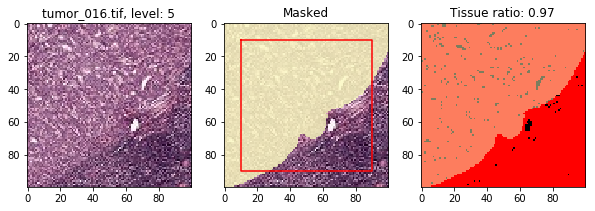

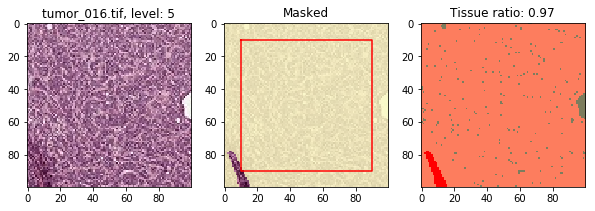

downloading .. Level 5,Length 1


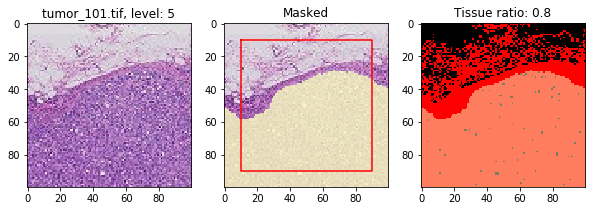

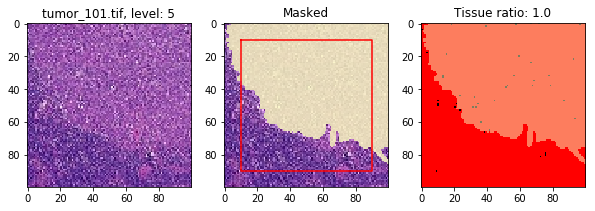

downloading .. Level 5,Length 2


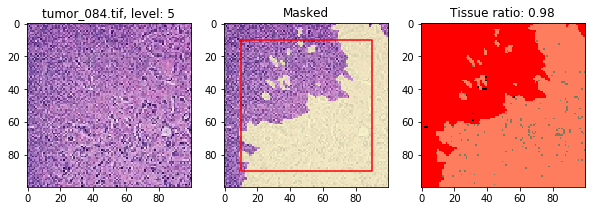

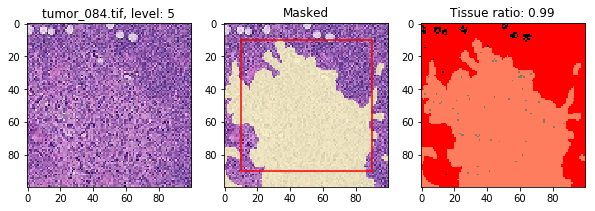

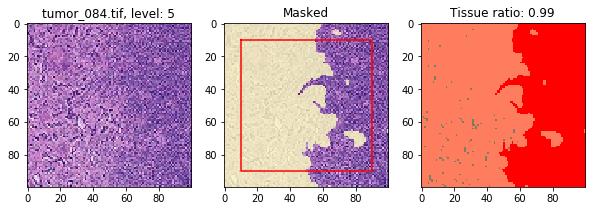

downloading .. Level 5,Length 3


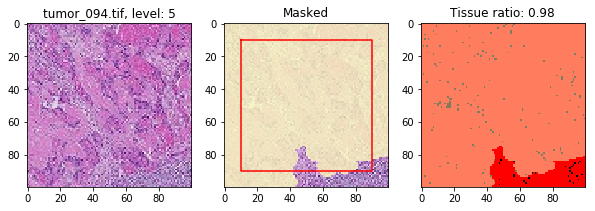

downloading .. Level 5,Length 4


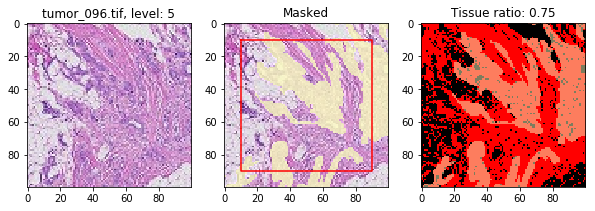

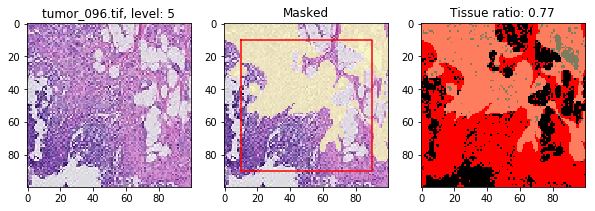

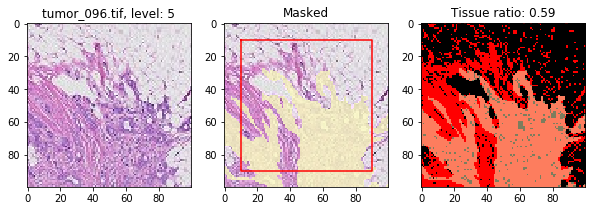

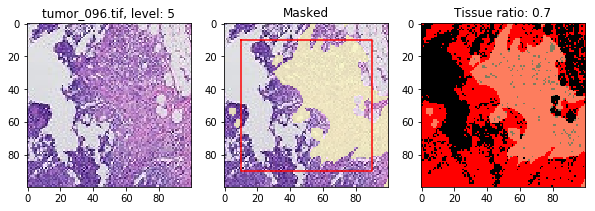

downloading .. Level 5,Length 5


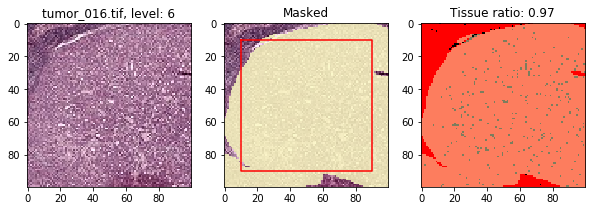

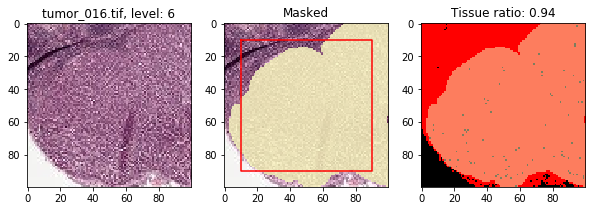

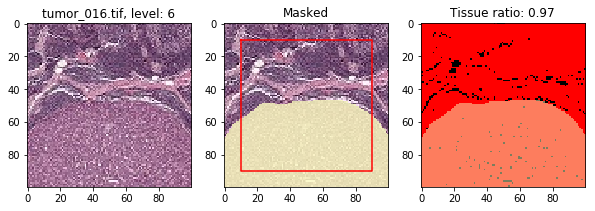

downloading .. Level 6,Length 1


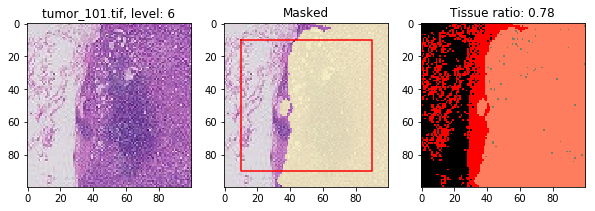

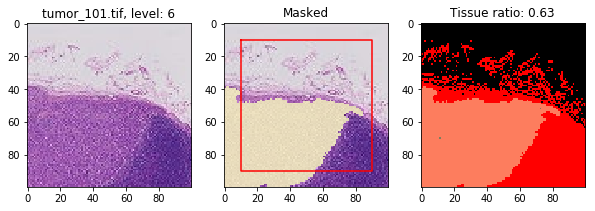

downloading .. Level 6,Length 2


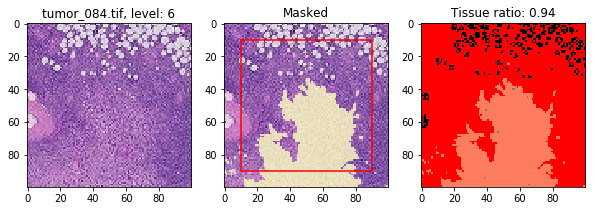

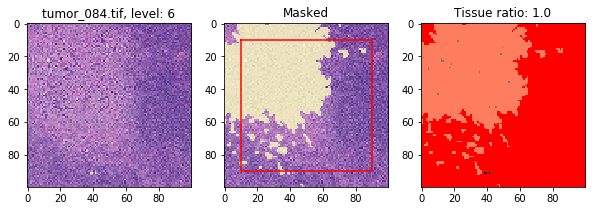

downloading .. Level 6,Length 3


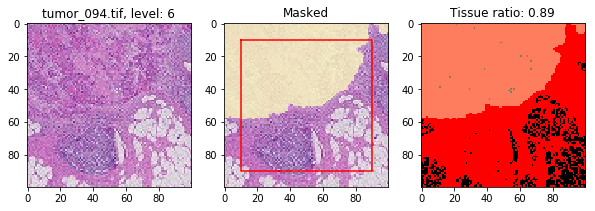

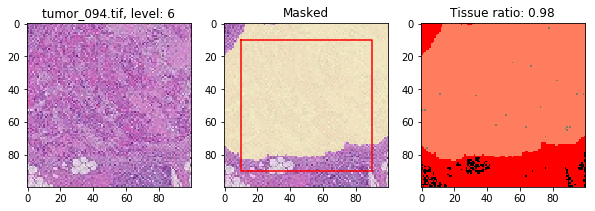

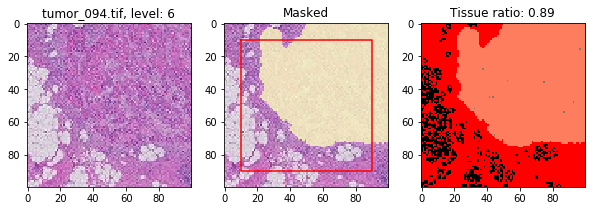

downloading .. Level 6,Length 4


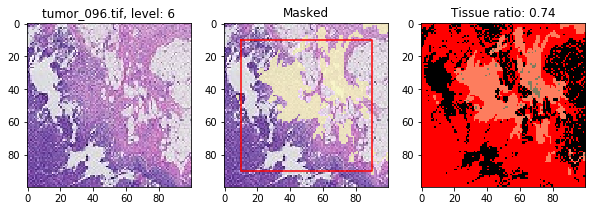

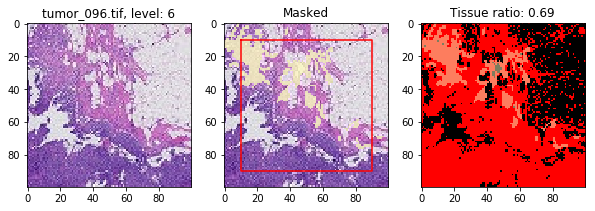

downloading .. Level 6,Length 5


In [0]:
training_data, training_label = [], []

for k in [5, 6]:
  for i in range(len(slide_data)):

    img, label = collect_sample(slide=slide_data[i], mask=mask_data[i], level=k, img=train_slides[i])
    training_data.extend(img)
    training_label.extend(label)
    
    #print('.')
    print("downloading .. Level %s,Length %s" % (k, i+1))

In [0]:
from keras.utils import to_categorical
training_label = to_categorical(training_label, 2)

In [0]:
np.save('training_data3.npy', np.array(training_data))
np.save('training_label3.npy', np.array(training_label))

In [0]:
#save training_data.npy & training_label.npy in google drive

train_data_file = drive.CreateFile({'train_data_file' : 'training_data3.npy'})                       
train_data_file.SetContentFile('training_data3.npy')                       
train_data_file.Upload()

train_label_file = drive.CreateFile({'train_label_file' : 'training_label3.npy'})                       
train_label_file.SetContentFile('training_label3.npy')                       
train_label_file.Upload()

### Directly Load data & label.npy from Google Drive to Colab

WARNING: need to install required packages previously

In [0]:
# https://drive.google.com/open?id=1b6N7RCz_wFiyYFcQtsq78l1eAIHnW3zL
# https://drive.google.com/open?id=1WDX3BdVAZcq7UyDKrQt_SHY5TnFxIYwD

In [0]:
# download google drive file to colab

#<id> : 1XJBZFnxuM00EgOwBg_Wlcoohw5g2L-PO
training_data = drive.CreateFile({'id': '1XJBZFnxuM00EgOwBg_Wlcoohw5g2L-PO'})
training_data.GetContentFile('training_data.npy')

#<id> : 1c4Ls7ygYBr9G8CCPRNt0UqfC2o3-7OMH
training_label = drive.CreateFile({'id': '1c4Ls7ygYBr9G8CCPRNt0UqfC2o3-7OMH'})
training_label.GetContentFile('training_label.npy')

In [0]:
training_data = np.load('training_data.npy')
training_label = np.load('training_label.npy')

In [0]:
training_label = np.array(training_label)
training_data = np.array(training_data)
print(training_data.shape)

(3000, 299, 299, 3)


In [0]:
print(training_label.shape)

(3000, 2)


In [0]:
#spllit the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(training_data.astype('float32'), training_label, 
                                                  random_state = 777, 
                                                  stratify = training_label, 
                                                  test_size= 0.2, shuffle = True)

In [0]:
x_train /= 255
x_test /= 255

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 299, 299, 3)
(600, 299, 299, 3)
(2400, 2)
(600, 2)


##Transfer Learning 

In [0]:
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.patches as mpatches
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [0]:
BATCH_SIZE =32
EPOCHS = 10

### Inception

In [0]:
model_inception = Sequential()
model_inception.add(InceptionV3(include_top= False, input_shape=(299, 299, 3)))
model_inception.add(Flatten())
model_inception.add(Dense(128, activation='relu'))
model_inception.add(Dense(2, activation='sigmoid'))
model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 38,580,386
Trainable params: 38,545,954
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
model_inception.compile(loss="binary_crossentropy", optimizer = Adam(lr=1e-5), metrics=['accuracy'])

In [0]:
# Fit the model
history_v3 = model_inception.fit(x_train, y_train, batch_size=BATCH_SIZE,
                              epochs = EPOCHS, 
                              validation_split =0.2,
                              verbose = 2,
                              shuffle=True
                              )

Instructions for updating:
Use tf.cast instead.
Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 62s - loss: 0.3975 - acc: 0.8107 - val_loss: 0.1408 - val_acc: 0.9635
Epoch 2/10
 - 36s - loss: 0.0538 - acc: 0.9924 - val_loss: 0.0580 - val_acc: 0.9896
Epoch 3/10
 - 36s - loss: 0.0154 - acc: 0.9997 - val_loss: 0.0414 - val_acc: 0.9906
Epoch 4/10
 - 36s - loss: 0.0100 - acc: 0.9997 - val_loss: 0.0349 - val_acc: 0.9885
Epoch 5/10
 - 36s - loss: 0.0045 - acc: 0.9997 - val_loss: 0.0263 - val_acc: 0.9906
Epoch 6/10
 - 36s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9906
Epoch 7/10
 - 36s - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0229 - val_acc: 0.9906
Epoch 8/10
 - 36s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9938
Epoch 9/10
 - 36s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9938
Epoch 10/10
 - 36s - loss: 9.1581e-04 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9948


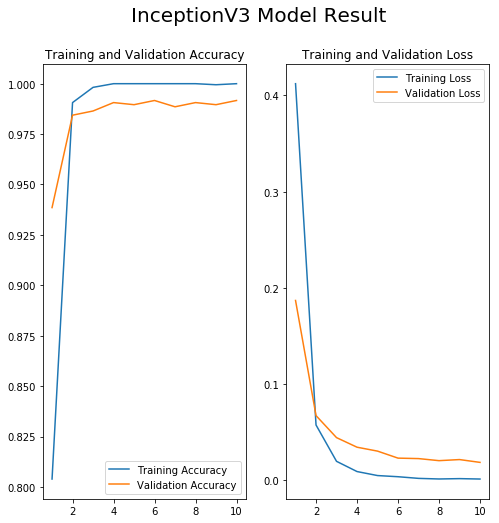

In [0]:
acc_v3 = history_v3.history['acc']
val_acc_v3 = history_v3.history['val_acc']

loss_v3 = history_v3.history['loss']
val_loss_v3 = history_v3.history['val_loss']

epochs_range = range(1, EPOCHS+1)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_v3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_v3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_v3, label='Training Loss')
plt.plot(epochs_range, val_loss_v3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.suptitle("InceptionV3 Model Result", size=20)

plt.show()

In [0]:
#save model
model_inception.save('model_inception_adam.h5')

In [0]:
#upload to your google drive

model_inception_file = drive.CreateFile({'model_inception_adam' : 'model_inception_adam.h5'})                       
model_inception_file.SetContentFile('model_inception_adam.h5')                       
model_inception_file.Upload()

In [0]:
#get the model load using keras
#copy id from previous line
#check id via google drive link

# https://drive.google.com/open?id=<id>
# replace id: 16fWVTCbMnr5ojMZ2DkfhN5lf9ZQ95so6
# adam: https://drive.google.com/open?id=1vwaDM1459uAcZtS5wXksbhcgSmNHr__w
v3_model_file_obj = drive.CreateFile({'id': '1vwaDM1459uAcZtS5wXksbhcgSmNHr__w'})                       
v3_model_file_obj.GetContentFile('model_inception_adam.h5')
model_inception = keras.models.load_model('model_inception_adam.h5')

In [0]:
print('test data Accuracy in Inception V3: ',model_inception.evaluate(x_test, y_test)[1])

600/600 [==============================] - 9s 15ms/step
test data Accuracy in Inception V3:  0.9891666666666666


In [0]:
# Evaluation Metrics

y_predict_v3 = model_inception.predict(x_test)
y_pred_v3 = np.argmax(y_predict_v3, axis=1)
precision_v3= precision_score(np.argmax(y_test, axis=1), y_pred_v3)
recall_v3= recall_score(np.argmax(y_test, axis=1), y_pred_v3)
f1_v3 = f1_score(np.argmax(y_test, axis=1), y_pred_v3)
auc_v3 = roc_auc_score(y_test, y_predict_v3)
print('Inception V3 -- ')
print('Precision: %s, Recall : %s, AUC : %s' %(precision_v3, recall_v3, auc_v3))

Inception V3 -- 
Precision: 0.9932659932659933, Recall : 0.9833333333333333, AUC : 0.999611111111111


### VGG16

In [0]:
model_vgg = Sequential()
model_vgg.add(VGG16(include_top= False, input_shape = (299, 299, 3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dense(2, activation='sigmoid'))

model_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5308544   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 20,023,490
Trainable params: 20,023,490
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_vgg.compile(loss="binary_crossentropy", optimizer = Adam(lr=1e-5), metrics=['accuracy'])

In [0]:
# Fit the model

history_vgg = model_vgg.fit(x_train, y_train, batch_size=BATCH_SIZE,
                              epochs = EPOCHS, 
                              validation_split =0.2,
                              verbose = 2,
                              shuffle=True
                              )

Instructions for updating:
Use tf.cast instead.
Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 70s - loss: 0.4896 - acc: 0.7510 - val_loss: 0.2430 - val_acc: 0.9135
Epoch 2/10
 - 56s - loss: 0.1280 - acc: 0.9586 - val_loss: 0.0764 - val_acc: 0.9771
Epoch 3/10
 - 56s - loss: 0.0215 - acc: 0.9977 - val_loss: 0.0363 - val_acc: 0.9885
Epoch 4/10
 - 56s - loss: 0.0059 - acc: 0.9997 - val_loss: 0.0245 - val_acc: 0.9927
Epoch 5/10
 - 56s - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0657 - val_acc: 0.9750
Epoch 6/10
 - 56s - loss: 0.0049 - acc: 0.9995 - val_loss: 0.0221 - val_acc: 0.9917
Epoch 7/10
 - 56s - loss: 6.7342e-04 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9917
Epoch 8/10
 - 55s - loss: 3.7259e-04 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 0.9927
Epoch 9/10
 - 55s - loss: 1.9688e-04 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9917
Epoch 10/10
 - 55s - loss: 1.5410e-04 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9938


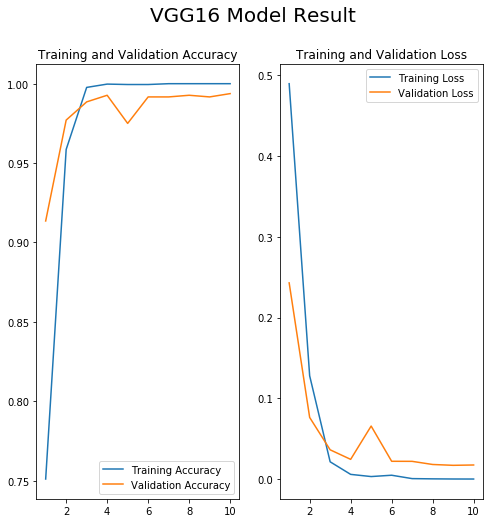

In [0]:
acc_vgg = history_vgg.history['acc']
val_acc_vgg = history_vgg.history['val_acc']

loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

epochs_range = range(1, EPOCHS+1)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_vgg, label='Training Accuracy')
plt.plot(epochs_range, val_acc_vgg, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_vgg, label='Training Loss')
plt.plot(epochs_range, val_loss_vgg, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.suptitle("VGG16 Model Result", size=20)

plt.show()

In [0]:
#save model
model_vgg.save('vgg_model_adam.h5')

In [0]:
#upload to your google drive

model_vgg_file = drive.CreateFile({'model_vgg_adam' : 'vgg_model_adam.h5'})                       
model_vgg_file.SetContentFile('vgg_model_adam.h5')                       
model_vgg_file.Upload()

In [0]:
#get the model load using keras
#copy id from previous line

# https://drive.google.com/open?id=<id> 
# replace id: 1hOFG_mjHdiFlmG3ZlHJ5uBwahB1_sxEk
# adamL: https://drive.google.com/open?id=1DmNKFiRo5OdyledC5AdhXfKiG5VY0U3R
vgg_model_file_obj = drive.CreateFile({'id': '1DmNKFiRo5OdyledC5AdhXfKiG5VY0U3R'})                       
vgg_model_file_obj.GetContentFile('vgg_model_adam.h5')
model_vgg = keras.models.load_model('vgg_model_adam.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
print('test data Accuracy in VGG16: ',model_vgg.evaluate(x_test, y_test)[1])

600/600 [==============================] - 9s 15ms/step
test data Accuracy in VGG16:  0.9958333333333333


In [0]:
# Evaluation Metrics

y_predict_vgg = model_vgg.predict(x_test)
y_pred_vgg = np.argmax(y_predict_vgg, axis=1)
precision_vgg = precision_score(np.argmax(y_test, axis=1), y_pred_vgg)
recall_vgg = recall_score(np.argmax(y_test, axis=1), y_pred_vgg)
#f1_vgg = f1_score(np.argmax(y_test, axis=1), y_pred_vgg)
auc_vgg = roc_auc_score(y_test, y_predict_vgg)
print('VGG16 -- ')
print('Precision: %s, Recall : %s, AUC : %s' %(precision_vgg, recall_vgg, auc_vgg))

VGG16 -- 
Precision: 0.9933554817275747, Recall : 0.9966666666666667, AUC : 0.9999277777777777


## Model Evaluation

### Test unseen image - Slide & Mask as prediction image



Write a script that takes your trained model and a testing image, and outputs a heat map showing the cancerous regions.

In [0]:
test_slides = ['tumor_110.tif']
test_masks = ['tumor_110_mask.tif']

In [0]:
# replace <folder_id> :drive.google.com/drive/u/0/folders/<folder ID>
file_list = drive.ListFile({'q': "title contains 'tumor' and title contains '.tif'"}).GetList()

In [0]:
for f in file_list:
  if f['title'] in test_slides or f['title'] in test_masks:
    fname_test = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(fname_test))
    f_test = drive.CreateFile({'id': f['id']})
    f_test.GetContentFile(fname_test)


In [0]:
def data_patches(slide, mask, level, x, y, patch_size):
    
    # read slide
    patch_image = read_slide(slide,
                             x = x,
                             y = y, 
                             level = level,
                             width = patch_size,
                             height = patch_size)
    
    # read tumor mask
    patch_mask = read_slide(mask,
                            x = x,
                            y = y, 
                            level = level,
                            width = patch_size,
                            height = patch_size)
    
    patch_mask = patch_mask[:,:,0]
    tissue_pixels = find_tissue_pixels(patch_image)
    patch_tissue = apply_mask(patch_image, tissue_pixels)
    
    return patch_image, patch_mask, patch_tissue

In [0]:
def get_reference(slide, mask, level = 7, x =0, y=0):

  slide_region = read_slide(slide, 
                           x=x, 
                           y=y, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  mask_region = read_slide(mask, 
                           x=x, 
                           y=y, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])[:,:,0]
  tissue_region = apply_mask(slide_region, find_tissue_pixels(slide_region))
  fig, axes = plt.subplots(1,3,figsize = (20,10), dpi=100)
  axes[0].imshow(slide_region)
  axes[1].imshow(mask_region)
  axes[2].imshow(tissue_region)
  plt.show()
  return slide_region, mask_region, tissue_region

In [0]:
from matplotlib.colors import Normalize
def plot_pred(prediction, slide, mask):
  fig, axes = plt.subplots(1,2, figsize=(10,10), dpi=100)
  
  
  colors = plt.cm.magma(Normalize(0, 1)(mask))

  colors[..., -1] = mask/np.max(mask)

  a = axes[0]
  a.imshow(slide)
  a.imshow(colors, cmap='viridis', vmin=0, vmax=1, alpha=0.7)
  a.set_xticks([]), axes[0].set_yticks([])
  a.set_title('Reference')

  
  a = axes[1]
  

  colors = plt.cm.magma(Normalize(0, 1)(prediction))
  colors[..., -1] = prediction/np.max(prediction)

  a.imshow(slide)
  a.imshow(colors, cmap='magma', vmin=0, vmax=1, alpha=0.7)
  a.set_xticks([]), axes[1].set_yticks([])
  a.set_title('PRED')
  plt.show()

In [0]:
def sliding(slide_file, mask_file, model, ref_level = 7, zoom_level = 5, patch_size = 299):
  slide = open_slide(slide_file)
  mask = open_slide(mask_file)
  slide_region, mask_region, tissue_region = get_reference(slide, mask, ref_level)
  
  results = np.zeros(slide_region.shape[:2])
  truth, pred = [], []
  stride = 2 ** zoom_level
  
  
  coords = []
  
  print(stride)
  for x in range(0, slide.level_dimensions[ref_level][1] - stride, stride):

    for y in range(0, slide.level_dimensions[ref_level][0] - stride, stride):
      
      if tissue_region[x, y, 0]:
        coords.append((x,y))
        new_x = x * (2**ref_level) - (patch_size // 2)*(2**zoom_level)
        new_y = y * (2**ref_level) - (patch_size // 2)*(2**zoom_level)
        
        patch_slide, patch_mask, patch_tissue = data_patches(slide, mask, zoom_level, patch_size = patch_size, x=new_x, y=new_y)
        
        
        if hasTumor(patch_mask):
          truth.append(1)
        else:
          truth.append(0)
        
        
        test_patch = patch_slide.astype(float).reshape(1, patch_size, patch_size, 3)
        test_patch /= 255.
        test_pred = np.argmax(model.predict(test_patch))
        pred.append(test_pred)
        
          
    for label, coord in zip(pred, coords):
      if zoom_level:
        offset = stride // 2
        results[coord[0] - offset : coord[0] + offset, coord[1] - offset : coord[1] + offset] = label
      else:
        results[coord[0], coord[1]] = label
  plot_pred(results, slide_region, mask_region)
  
  return truth, pred
        


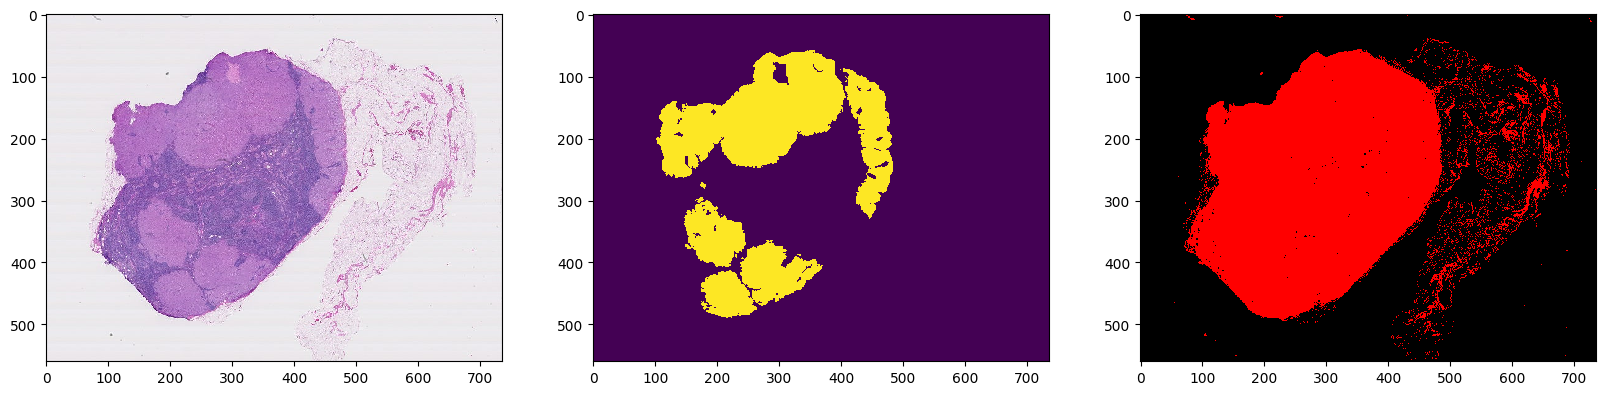

32


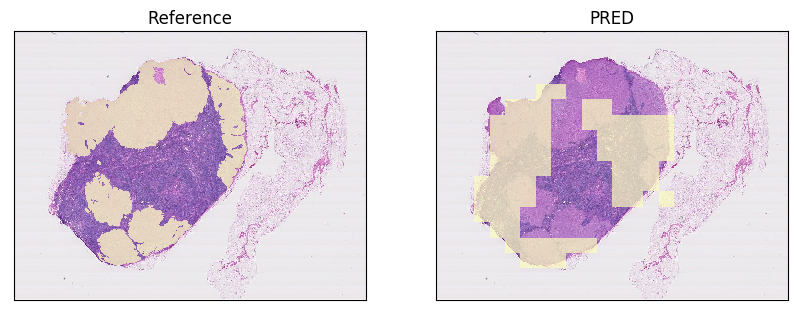

Accuracy: 0.86
Recall: 0.78
Precision: 0.99
F1 Score: 0.87


In [0]:
from sklearn.metrics import confusion_matrix


all_truth, all_pred = [], []
for i in range(len(test_slides)):
  path = '/root/data/'
  truth, pred = sliding(path+test_slides[i], path+test_masks[i], model_inception)
  all_truth.extend(truth)
  all_pred.extend(pred)
  
tn, fp, fn, tp = confusion_matrix(all_truth, all_pred).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)